
Sentiment Counts:
positive    8984
negative     970
neutral      307
Name: sentiment, dtype: int64

Sentiment Percentages:
positive    87.554819
negative     9.453270
neutral      2.991911
Name: sentiment, dtype: float64

Sentiment Distribution by Ratings:
sentiment  negative   neutral  positive
overall                                
1.0        0.483871  0.082949  0.433180
2.0        0.360000  0.056000  0.584000
3.0        0.191710  0.049223  0.759067
4.0        0.106526  0.034549  0.858925
5.0        0.058374  0.023782  0.917844

Top Keywords in Negative Reviews:
[('the', 3594), ('i', 2237), ('a', 2062), ('it', 1842), ('to', 1838), ('and', 1808), ('of', 1071), ('is', 1003), ('this', 977), ('for', 882), ('on', 762), ('with', 759), ('that', 744), ('my', 726), ('but', 719), ('you', 690), ('in', 642), ('have', 609), ('not', 604), ('guitar', 436)]

Sentiment Trends Over Years:
sentiment  negative  neutral  positive
year                                  
2004              1        0      

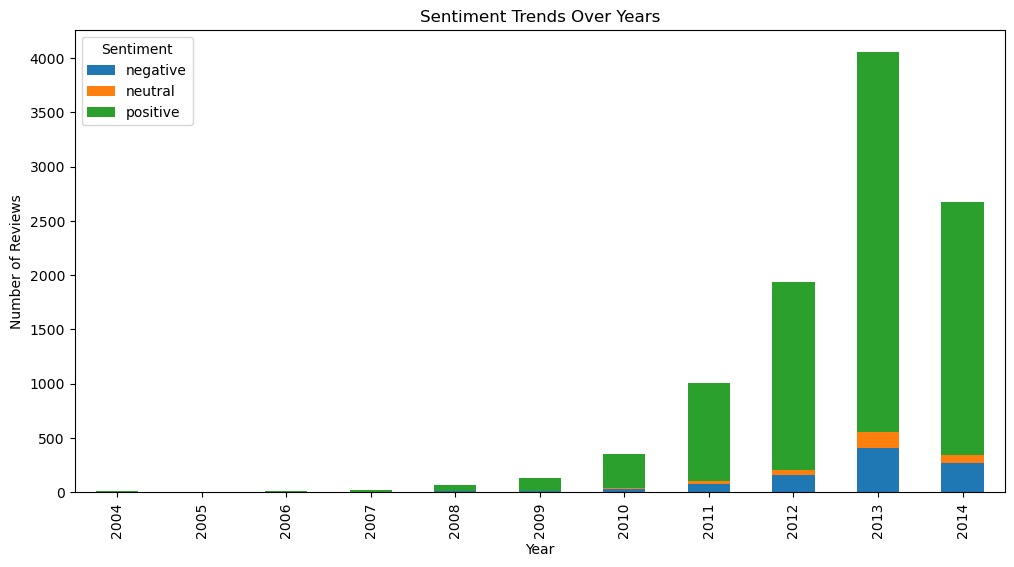


Sentiment Distribution for Top Products:
sentiment   negative  neutral  positive
asin                                   
B0002E1G5C         9        9       125
B0002F7K7Y         3        3       110
B0002H0A3S         8        1        84
B003VWJ2K8        15        3       145
B003VWKPHC         7        3       104

Average Review Length by Sentiment:
sentiment
negative    385.269072
neutral     217.114007
positive    485.620325
Name: review_length, dtype: float64

Top 10 Reviewers by Review Count:
ADH0O8UVJOT10     42
A15TYOEWBQYF0X    38
A1L7M2JXN4EZCR    38
A2EZWZ8MBEDOLN    36
A2NYK9KWFMJV4Y    34
A1SD1C8XK3Z3V1    32
A1MVH1WLYDHZ49    32
A1GMWTGXW682GB    29
A34O0KQV4QXWNQ    28
A1LQC225SE8UNI    27
Name: reviewerID, dtype: int64

Average Sentiment Score by Top Reviewers:
reviewerID
A15TYOEWBQYF0X    0.784176
A1GMWTGXW682GB    0.674462
A1L7M2JXN4EZCR    0.594655
A1LQC225SE8UNI    0.596044
A1MVH1WLYDHZ49    0.468059
A1SD1C8XK3Z3V1    0.822875
A2EZWZ8MBEDOLN    0.756833
A2NYK9K

In [15]:
import pandas as pd
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
from collections import Counter
import re
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# Call the function to check/download the lexicon
ensure_vader_lexicon()

# Initialize VADER SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()


# Initialize VADER SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()

# Call the function to check/download the lexicon
ensure_vader_lexicon()

# Initialize VADER SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()


# Initialize VADER sentiment analyzer
sid = SentimentIntensityAnalyzer()

# File path to the cleaned dataset
file_path = '/Users/dinabandhupanigrahi/customer-sentiment-dashboard/data/processed/Musical_Instruments_cleaned.csv'

# Load the dataset
df = pd.read_csv(file_path)

# Add review_length column to calculate the length of each review
df['review_length'] = df['reviewText'].fillna('').apply(len)

# Ensure reviewText contains only strings
df['reviewText'] = df['reviewText'].fillna('').astype(str)

# Apply sentiment analysis
df['sentiment_score'] = df['reviewText'].apply(lambda x: sid.polarity_scores(x)['compound'])

# Classify sentiments based on scores
df['sentiment'] = df['sentiment_score'].apply(lambda x: 'positive' if x > 0.05 else 'negative' if x < -0.05 else 'neutral')

# Display sentiment counts
print("\nSentiment Counts:")
print(df['sentiment'].value_counts())
print("\nSentiment Percentages:")
print(df['sentiment'].value_counts(normalize=True) * 100)

# Sentiment distribution by rating
sentiment_by_rating = df.groupby('overall')['sentiment'].value_counts(normalize=True).unstack()
print("\nSentiment Distribution by Ratings:")
print(sentiment_by_rating)

# Filter negative reviews
negative_reviews = df[df['sentiment'] == 'negative']

# Extract most common words in negative reviews
def extract_keywords(texts):
    words = re.findall(r'\b\w+\b', ' '.join(texts).lower())
    return Counter(words).most_common(20)

negative_keywords = extract_keywords(negative_reviews['reviewText'])
print("\nTop Keywords in Negative Reviews:")
print(negative_keywords)

# Group by year and calculate sentiment counts
df['year'] = pd.to_datetime(df['reviewTime'], format='%m %d, %Y').dt.year
sentiment_trends = df.groupby(['year', 'sentiment']).size().unstack(fill_value=0)

print("\nSentiment Trends Over Years:")
print(sentiment_trends)

# Plot sentiment trends
sentiment_trends.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.title('Sentiment Trends Over Years')
plt.xlabel('Year')
plt.ylabel('Number of Reviews')
plt.legend(title='Sentiment')
plt.show()

# Sentiment distribution for top products
top_products = df['asin'].value_counts().head(5).index
product_sentiments = df[df['asin'].isin(top_products)].groupby(['asin', 'sentiment']).size().unstack(fill_value=0)

print("\nSentiment Distribution for Top Products:")
print(product_sentiments)

# Average review length by sentiment
length_by_sentiment = df.groupby('sentiment')['review_length'].mean()
print("\nAverage Review Length by Sentiment:")
print(length_by_sentiment)

# Identify top 10 reviewers by number of reviews
top_reviewers = df['reviewerID'].value_counts().head(10)
print("\nTop 10 Reviewers by Review Count:")
print(top_reviewers)

# Filter data for top reviewers
top_reviewers_data = df[df['reviewerID'].isin(top_reviewers.index)].copy()  # Use .copy() to avoid SettingWithCopyWarning

# Apply sentiment analysis to top reviewers
top_reviewers_data['sentiment_score'] = top_reviewers_data['reviewText'].apply(
    lambda x: sid.polarity_scores(str(x))['compound']
)

# Average sentiment score for each top reviewer
sentiment_by_reviewer = top_reviewers_data.groupby('reviewerID')['sentiment_score'].mean()
print("\nAverage Sentiment Score by Top Reviewers:")
print(sentiment_by_reviewer)

# Vectorize review text data for topic modeling
vectorizer = CountVectorizer(max_df=0.9, min_df=2, stop_words='english')
review_matrix = vectorizer.fit_transform(top_reviewers_data['reviewText'].fillna(''))

# Perform LDA with 3 topics
lda = LatentDirichletAllocation(n_components=3, random_state=42)
lda.fit(review_matrix)

# Display top words for each topic
print("\nTop Words for Each Topic:")
words = vectorizer.get_feature_names_out()
for idx, topic in enumerate(lda.components_):
    print(f"Topic {idx}: {', '.join([words[i] for i in topic.argsort()[-10:]])}")

# Correlation between review length and sentiment score
correlation_length_sentiment = top_reviewers_data['review_length'].corr(top_reviewers_data['sentiment_score'])
print(f"\nCorrelation between review length and sentiment: {correlation_length_sentiment:.2f}")
